In [1]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve
import numpy as np
from tqdm import tqdm

2025-05-04 10:55:12.727240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746356112.751654     233 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746356112.758784     233 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
fake = pd.read_csv('/kaggle/input/fake-news-detection/Fake.csv')[['title', 'text']].assign(label=0)
real = pd.read_csv('/kaggle/input/fake-news-detection/True.csv')[['title', 'text']].assign(label=1)

df   = pd.concat([fake, real]).sample(frac=1, random_state=42).reset_index(drop=True)

# Check for exact duplicate rows
duplicates = df[df.duplicated()]
print("df length before removing duplicates:",len(df))

df = df.drop_duplicates().reset_index(drop=True)
print("df length after removing duplicates:",len(df))

df.head(5)

df length before removing duplicates: 44898
df length after removing duplicates: 39105


,title,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


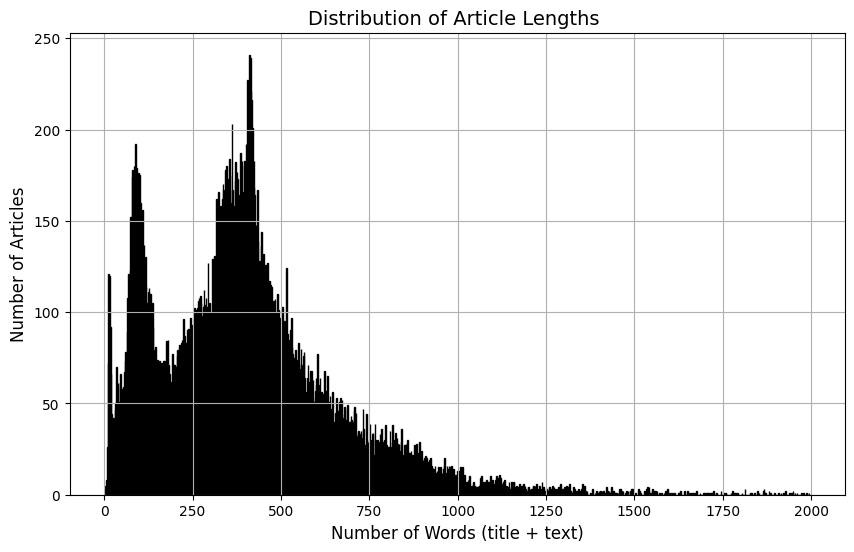

In [4]:

# Calculate word count for each article
df['word_count'] = (df['title'] + ' ' + df['text']).apply(lambda x: len(x.split()))

# Filter for word count 
filtered_counts = df[df['word_count'] <= 2000]['word_count']

# Plot histogram
plt.figure(figsize=(10,6))
plt.hist(filtered_counts, bins=1000, color='lightgreen', edgecolor='black')
plt.xlabel('Number of Words (title + text)', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.title('Distribution of Article Lengths ', fontsize=14)
plt.grid(True)
plt.show()



In [5]:
def clean_text(text):
    # Lowercase
    # text = text.lower()   use if we are using uncased bert tokeniser
    
    # Remove URLs (http, https, www, t.co, bit.ly, etc.)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove @mentions and #hashtags (common in tweets)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


print("ORIGINAL TEXT\n:",df["text"][3],end="\n\n")
print("CLEANED TEXT:\n",df["text"].apply(clean_text)[3])


df['content'] = (df['title'] + ' ' + df['text']).fillna('').apply(clean_text)

X = df['content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)                                                          # first found that we had duplicates in the X
                                                           # so we had overlap in x_train and test.thats why duplicates 
                                                           # are removed

ORIGINAL TEXT
: On Monday, Donald Trump once again embarrassed himself and his country by accidentally revealing the source of the extremely classified information he leaked to Russia earlier this month.While it was speculated that the source of the information was Israel, Trump made things crystal clear during a press conference with Prime Minister Benjamin Netanyahu. President Pussygrabber explained that he never   not once   said  Israel  during his conversation with the Russian recipients of the leaked information. Not a single time. Just so you understand I never mentioned the word or the name  Israel,  Trump said.  I never mentioned it during that conversation. They were all saying I did,  Trump said, gesturing to reporters.  So you had another story wrong. Never mentioned the word  Israel . He may not have said the word Israel,  but according to reports Israeli intelligence officials  were shouting at US counterparts  over the leaked information.Now, he accidentally-perhaps-on-p

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Longformer (Cased, 4096 Tokens)
# Model: allenai/longformer-base-4096
# Input Limit: Up to 4096 tokens
# Casing: Yes, it is case-sensitive (uses RoBERTa tokenizer which is cased)
# Architecture: Efficient attention for long sequences
# Best For: Long articles like news, research papers, legal docs   can be used but our size is mostly 512 tokens

class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.enc = tokenizer(
            texts.tolist(),
            max_length=512,
            truncation=True,
            padding='max_length'
        )
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_ds = NewsDataset(X_train, y_train)
test_ds  = NewsDataset(X_test,  y_test)

# Use num_workers=0 to avoid CUDA in subprocesses, and pin_memory for faster host->device transfer
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

In [7]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=2
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
summary(model, input_size=(8, 512), dtypes=[torch.long])

Layer (type:depth-idx)                                       Output Shape              Param #
BertForSequenceClassification                                [8, 2]                    --
├─BertModel: 1-1                                             [8, 768]                  --
│    └─BertEmbeddings: 2-1                                   [8, 512, 768]             --
│    │    └─Embedding: 3-1                                   [8, 512, 768]             22,268,928
│    │    └─Embedding: 3-2                                   [8, 512, 768]             1,536
│    │    └─Embedding: 3-3                                   [1, 512, 768]             393,216
│    │    └─LayerNorm: 3-4                                   [8, 512, 768]             1,536
│    │    └─Dropout: 3-5                                     [8, 512, 768]             --
│    └─BertEncoder: 2-2                                      [8, 512, 768]             --
│    │    └─ModuleList: 3-6                                  --             

In [8]:

# Save model function
def save_model(model, epoch, output_dir='./saved_model'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model_path = os.path.join(output_dir, f"model_epoch_{epoch}.bin")
    torch.save(model.state_dict(), model_path)
    print(f" Model saved at epoch {epoch} to {model_path}")

# Early stopping settings
early_stop_patience = 1   # stop if no improvement for 2 consecutive epochs
best_auc = 0.0
epochs_without_improve = 0

# Training loop with early stopping
for epoch in range(1, epochs + 1):
    print(f"\n Epoch {epoch}/{epochs}")
    
    model.train()
    total_loss = 0.0

    # Training with progress bar
    train_loop = tqdm(train_loader, desc=' Training', leave=False)
    for batch in train_loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    val_loop = tqdm(val_loader, desc=' Validating', leave=False)
    with torch.no_grad():
        for batch in val_loop:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch['labels'].cpu().numpy()
            logits = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            ).logits
            probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = np.argmax(logits.cpu().numpy(), axis=1)

            all_labels.extend(labels)
            all_preds.extend(preds)
            all_probs.extend(probs)

    acc  = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    auc  = roc_auc_score(all_labels, all_probs)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    eer = fpr[np.nanargmin(np.abs(1 - tpr - fpr))]

    print(f" Epoch {epoch} — Train Loss: {avg_train_loss:.4f} | "
          f"Val Acc: {acc:.4f}, Prec: {prec:.4f}, AUC: {auc:.4f}, EER: {eer:.4f}")

    # Check for early stopping
    if auc > best_auc:
        best_auc = auc
        epochs_without_improve = 0
        save_model(model, epoch)
    else:
        epochs_without_improve += 1
        print(f" No improvement. Patience: {epochs_without_improve}/{early_stop_patience}")

    if epochs_without_improve >= early_stop_patience:
        print(" Early stopping triggered.")
        break



 Epoch 1/3


 Epoch 1 — Train Loss: 0.0370 | Val Acc: 0.9995, Prec: 0.9998, AUC: 1.0000, EER: 0.0003
 Model saved at epoch 1 to ./saved_model/model_epoch_1.bin

 Epoch 2/3


 Epoch 2 — Train Loss: 0.0005 | Val Acc: 0.9997, Prec: 1.0000, AUC: 0.9998, EER: 0.0000
 No improvement. Patience: 1/1
 Early stopping triggered.


In [18]:
from tqdm import tqdm  # Add this import

# Function to load the model from a saved file
def load_model(epoch, model, output_dir='./saved_model'):
    model_path = os.path.join(output_dir, f"model_epoch_{epoch}.bin")
    model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from {model_path}")
    return model

# Specify the epoch for the saved model you want to load
epoch_to_test = 1

# Load the model for the nth epoch
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2).to(device)
model = load_model(epoch_to_test, model)

# Test the loaded model
model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):  # Add tqdm here
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch['labels'].cpu().numpy()
        logits = model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        ).logits
        probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = np.argmax(logits.cpu().numpy(), axis=1)

        all_labels.extend(labels)
        all_preds.extend(preds)
        all_probs.extend(probs)

# Metrics calculation
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
eer = fpr[np.nanargmin(np.abs(1 - tpr - fpr))]

# Print metrics
print(f"Test — Accuracy: {acc:.4f}, Precision: {prec:.4f}, AUC: {auc:.4f}, EER: {eer:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_233/2899993643.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

Model loaded from ./saved_model/model_epoch_1.bin


Evaluating: 100%|██████████| 978/978 [01:58<00:00,  8.29it/s]

Test — Accuracy: 0.9995, Precision: 0.9998, AUC: 1.0000, EER: 0.0003
